In [1]:
#!python prepare_data_spleen.py

In [2]:
from cnn.model import build_net
from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#   except RuntimeError as e:
#     print(e)

2022-09-21 21:29:01.960182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 21:29:01.989670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 21:29:01.989809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
data_path = './data/Task09_Spleen_2D'

patch_size = (128, 128)
batch_size = 32
num_classes = 2

augmentation = get_training_augmentation(patch_size)

/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [4]:
patients = get_list_of_patients(dataset_folder)
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

train_patients, val_patients = get_split_deterministic(patients, fold=1, num_splits=5, random_state=0)

train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

In [5]:
len(train_dataset)

859

In [6]:
len(train_dataloader)

26

(512, 512)
(512, 512)


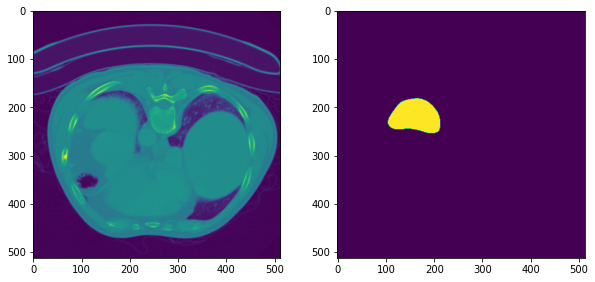

In [7]:
id = random.randint(0, len(train_dataset))
image, label = train_dataset[id]

print(image.shape)
print(label.shape)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(label)

(128, 128)
(128, 128)


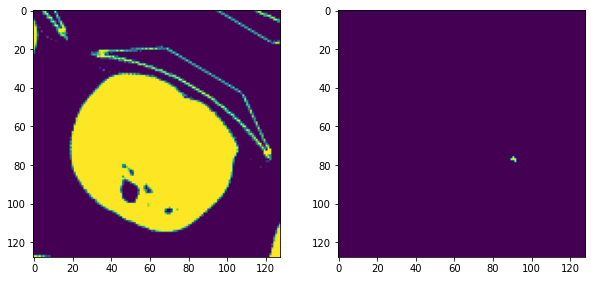

In [8]:
id = random.randint(0, len(train_dataloader))
images, labels = train_dataloader[id]

image = images[0]
label =labels[0]

print(image.shape)
print(label.shape)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(label)

In [9]:
net_list = [
    'vgg_3_1_32', 
    'vgg_3_1_64',
    'vgg_3_1_128',
    'vgg_3_1_256',
    'vgg_3_1_512',
    'vgg_3_1_256',
    'vgg_3_1_128',
    'vgg_3_1_64',
    'vgg_3_1_32'
]

fn_dict = {
    'vgg_1_1_32':       {'block': 'VGGBlock',       'params': {'kernel': 1, 'filters': 32},     'prob': 0.05},
    'vgg_1_1_64':       {'block': 'VGGBlock',       'params': {'kernel': 1, 'filters': 64},     'prob': 0.05},
    'vgg_3_1_32':       {'block': 'VGGBlock',       'params': {'kernel': 3, 'filters': 32},     'prob': 0.05},
    'vgg_3_1_64':       {'block': 'VGGBlock',       'params': {'kernel': 3, 'filters': 64},     'prob': 0.05},
    'vgg_3_1_128':      {'block': 'VGGBlock',       'params': {'kernel': 3, 'filters': 128},    'prob': 0.05},
    'vgg_3_1_256':      {'block': 'VGGBlock',       'params': {'kernel': 3, 'filters': 256},    'prob': 0.05},
    'vgg_3_1_512':      {'block': 'VGGBlock',       'params': {'kernel': 3, 'filters': 256},    'prob': 0.05},
    'vgg_5_1_32':       {'block': 'VGGBlock',       'params': {'kernel': 5, 'filters': 32},     'prob': 0.05},
    'vgg_5_1_64':       {'block': 'VGGBlock',       'params': {'kernel': 5, 'filters': 64},     'prob': 0.05},
    'vgg_5_1_128':      {'block': 'VGGBlock',       'params': {'kernel': 5, 'filters': 128},    'prob': 0.05},
    'vgg_5_1_256':      {'block': 'VGGBlock',       'params': {'kernel': 5, 'filters': 256},    'prob': 0.05},
    'resnet_1_1_32':    {'block': 'ResNetBlock',    'params': {'kernel': 1, 'filters': 32},     'prob': 0.05},
    'resnet_1_1_64':    {'block': 'ResNetBlock',    'params': {'kernel': 1, 'filters': 64},     'prob': 0.05},
    'resnet_3_1_32':    {'block': 'ResNetBlock',    'params': {'kernel': 3, 'filters': 32},     'prob': 0.05},
    'resnet_3_1_64':    {'block': 'ResNetBlock',    'params': {'kernel': 3, 'filters': 64},     'prob': 0.05},
    'resnet_3_1_128':   {'block': 'ResNetBlock',    'params': {'kernel': 3, 'filters': 128},    'prob': 0.05},
    'resnet_3_1_256':   {'block': 'ResNetBlock',    'params': {'kernel': 3, 'filters': 256},    'prob': 0.05},
    'resnet_5_1_32':    {'block': 'ResNetBlock',    'params': {'kernel': 5, 'filters': 32},     'prob': 0.05},
    'resnet_5_1_64':    {'block': 'ResNetBlock',    'params': {'kernel': 5, 'filters': 64},     'prob': 0.05},
    'resnet_5_1_128':   {'block': 'ResNetBlock',    'params': {'kernel': 5, 'filters': 128},    'prob': 0.05},
    'resnet_5_1_256':   {'block': 'ResNetBlock',    'params': {'kernel': 5, 'filters': 256},    'prob': 0.05},
      }

In [10]:
model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)
model.summary()

2022-09-21 21:29:48.170213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 21:29:48.175026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 21:29:48.176003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 21:29:48.176154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                               

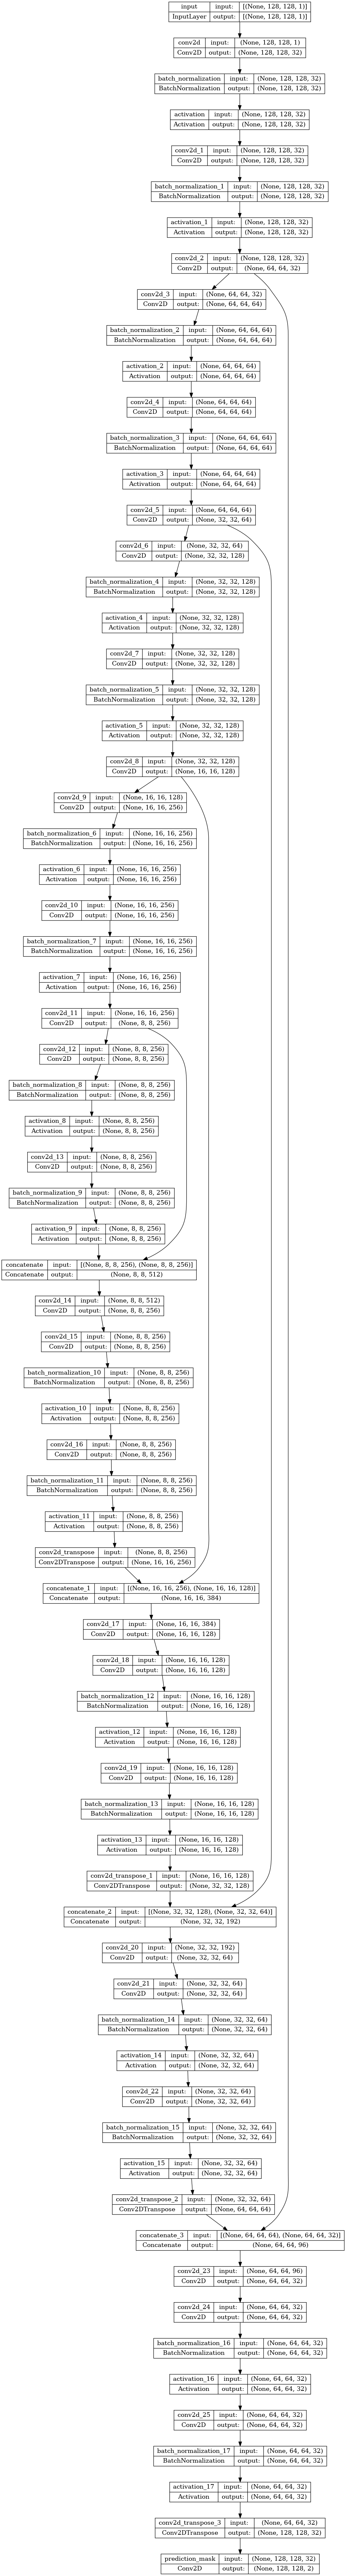

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('model.png')

In [48]:
history = model.fit(
    train_dataloader,
    validation_data=val_dataloader,
    epochs=100,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", verbose=1, patience=5
        ),
        ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
        ),
        TensorBoard(log_dir="./logs")
    ],
)

Epoch 1/100


2022-09-21 19:54:46.162454: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op net/conv2d_44/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-21 19:54:46.162513: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-09-21 19:54:46.162527: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 127, Chunks in use: 126. 31.8KiB allocated for chunks. 31.5KiB in use in bin. 15.2KiB client-requested in use in bin.
2022-09-21 19:54:46.162535: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 38, Chunks in use: 38. 19.0KiB allocated for chunks. 19.0KiB in use in bin. 19.0KiB client-requested in use in bin.
2022-09-21 19:

ResourceExhaustedError: Graph execution error:

Detected at node 'net/conv2d_44/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32139/2280649456.py", line 1, in <cell line: 1>
      history = model.fit(
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'net/conv2d_44/Conv2D'
OOM when allocating tensor with shape[32,32,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node net/conv2d_44/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11416]

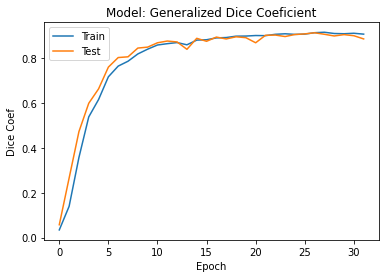

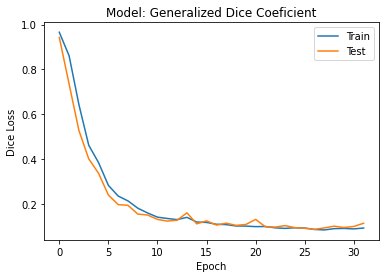

In [ ]:
# plotting the dice coeff results (accuracy) as a function of the number of epochs
plt.figure()
plt.plot(history.history['gen_dice_coef'])
plt.plot(history.history['val_gen_dice_coef'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plotting the dice coeff results (loss function) as a function of the number of epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
!tensorboard --logdir='./logs'

2022-08-12 20:45:19.278008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 20:45:19.304717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 20:45:19.304863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL